# Santander Value Prediction Plot

### by Ning Liu, Yilin Liu

In [33]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import lightgbm as lgb
import random
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
random.seed(2018)

/Users/yilinliu/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



### 1. Load train and test data

In [34]:
trainRaw = pd.read_csv('./data/train.csv')
testRaw = pd.read_csv('./data/test.csv')
train = trainRaw.drop(["ID", "target"], axis=1)
target = np.log1p(trainRaw["target"].values)
test = testRaw.drop(["ID"], axis=1)

### 2. Remove some constant and duplicate data

In [35]:
#remove constant
colsToRemove = []
for col in train.columns:
    if train[col].std() == 0: 
        colsToRemove.append(col)

train.drop(colsToRemove, axis=1, inplace=True)
test.drop(colsToRemove, axis=1, inplace=True) 

#remove duplicate
colsToRemove = []
colsScaned = []
dupList = {}
columns = train.columns
for i in range(len(columns)-1):
    v = train[columns[i]].values
    dupCols = []
    for j in range(i+1,len(columns)):
        if np.array_equal(v, train[columns[j]].values):
            colsToRemove.append(columns[j])
            if columns[j] not in colsScaned:
                dupCols.append(columns[j]) 
                colsScaned.append(columns[j])
                dupList[columns[i]] = dupCols                
train.drop(colsToRemove, axis=1, inplace=True) 
test.drop(colsToRemove, axis=1, inplace=True)

print("After remove Constant and Dup Train set size: {}".format(train.shape))
print("After remove Constant and Dup Test set size: {}".format(test.shape))


After remove Constant and Dup Train set size: (4459, 4730)
After remove Constant and Dup Test set size: (49342, 4730)


### 3. Perform feature learning

In [36]:
def addSumZeros(train, test, features):
    flist = [x for x in train.columns if not x in ['ID','target']]
    if 'SumZeros' in features:
        train.insert(1, 'SumZeros', (train[flist] == 0).astype(int).sum(axis=1))
        test.insert(1, 'SumZeros', (test[flist] == 0).astype(int).sum(axis=1))
    flist = [x for x in train.columns if not x in ['ID','target']]
    return train, test

def addSumValues(train, test, features):
    flist = [x for x in train.columns if not x in ['ID','target']]
    if 'SumValues' in features:
        train.insert(1, 'SumValues', (train[flist] != 0).astype(int).sum(axis=1))
        test.insert(1, 'SumValues', (test[flist] != 0).astype(int).sum(axis=1))
    flist = [x for x in train.columns if not x in ['ID','target']]
    return train, test

def addOtherAgg(train, test, features):
    flist = [x for x in train.columns if not x in ['ID','target','SumZeros','SumValues']]
    if 'OtherAgg' in features:
        train['Mean']   = train[flist].mean(axis=1)
        train['Median'] = train[flist].median(axis=1)
        train['Mode']   = train[flist].mode(axis=1)
        train['Max']    = train[flist].max(axis=1)
        train['Var']    = train[flist].var(axis=1)
        train['Std']    = train[flist].std(axis=1)
        
        test['Mean']   = test[flist].mean(axis=1)
        test['Median'] = test[flist].median(axis=1)
        test['Mode']   = test[flist].mode(axis=1)
        test['Max']    = test[flist].max(axis=1)
        test['Var']    = test[flist].var(axis=1)
        test['Std']    = test[flist].std(axis=1)
    flist = [x for x in train.columns if not x in ['ID','target','SumZeros','SumValues']]

    return train, test

train, test = addSumZeros(train, test, ['SumZeros'])
train, test = addSumValues(train, test, ['SumValues'])
train, test = addOtherAgg(train, test, ['OtherAgg'])


### Draw variance plot

In [37]:
#plot for variance
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import StandardScaler
init_notebook_mode(connected=True)
# Calculating Eigenvectors and eigenvalues
standardized_train = StandardScaler().fit_transform(train.values)
mean_vec = np.mean(standardized_train, axis=0)
cov_matrix = np.cov(standardized_train.T)
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
# Individual explained variance
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] 
var_exp_real = [v.real for v in var_exp]
# Cumulative explained variance
cum_var_exp = np.cumsum(var_exp) 
cum_exp_real = [v.real for v in cum_var_exp]
trace1 = go.Scatter(x=train.columns, y=var_exp_real, name="Individual Variance", opacity=0.75, marker=dict(color="red"))
trace2 = go.Scatter(x=train.columns, y=cum_exp_real, name="Cumulative Variance", opacity=0.75, marker=dict(color="black"))
layout = dict(height=400, title='Variance Explained by Variables', legend=dict(orientation="h", x=0, y=1.2));
fig = go.Figure(data=[trace1, trace2], layout=layout);
iplot(fig);

In [38]:
#Perform k means
flist_kmeans = []
flist = [x for x in train.columns if not x in ['ID','target']]
for ncl in range(2,11):
    cls = KMeans(n_clusters=ncl)
    cls.fit_predict(train[flist].values)
    train['kmeans_cluster_'+str(ncl)] = cls.predict(train[flist].values)
    test['kmeans_cluster_'+str(ncl)] = cls.predict(test[flist].values)


In [39]:
#Perform PCA
n_components = 20
flist_pca = []
pca = PCA(n_components=n_components)
flist = [x for x in train.columns if not x in ['ID','target']]
train_projected = pca.fit_transform(normalize(train[flist], axis=0))
test_projected = pca.transform(normalize(test[flist], axis=0))
for npca in range(0, n_components):
    train.insert(1, 'PCA_'+str(npca+1), train_projected[:, npca])
    test.insert(1, 'PCA_'+str(npca+1), test_projected[:, npca])

### Draw PCA plot

In [40]:
#draw PCA plot
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
def plot_3_components(x_trans, title):
    trace = go.Scatter3d(x=x_trans[:,0], y=x_trans[:,1], z = x_trans[:,2],
                          mode = 'markers', showlegend = False,
                          marker = dict(size = 8, color=x_trans[:,1], 
                          line = dict(width = 1, color = '#f7f4f4'), opacity = 0.5))
    layout = go.Layout(title = title, showlegend= True)
    fig = dict(data=[trace], layout=layout)
    iplot(fig)
plot_3_components(train_projected, 'First Three Component of PCA')

### Run model

In [41]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, 
                      verbose_eval=200, evals_result=evals_result)    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [42]:
# Training LGB
seeds = [42, 2018]
pred_test_full_seed = 0
for seed in seeds:
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=seed)
    pred_test_full = 0
    for dev_index, val_index in kf.split(train):
        dev_X, val_X = train.loc[dev_index,:], train.loc[val_index,:]
        dev_y, val_y = target[dev_index], target[val_index]
        pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test)
        pred_test_full += pred_test
    pred_test_full /= 5.
    pred_test_full = np.expm1(pred_test_full)
    pred_test_full_seed += pred_test_full
pred_test_full_seed /= np.float(len(seeds))
print("LightGBM Training Completed!!!")

Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.19687	valid_1's rmse: 1.37702
[400]	training's rmse: 1.01183	valid_1's rmse: 1.36497
[600]	training's rmse: 0.896778	valid_1's rmse: 1.36336
Early stopping, best iteration is:
[592]	training's rmse: 0.900839	valid_1's rmse: 1.36293
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.1841	valid_1's rmse: 1.42404
[400]	training's rmse: 0.999223	valid_1's rmse: 1.39722
Early stopping, best iteration is:
[425]	training's rmse: 0.982307	valid_1's rmse: 1.39663
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.19315	valid_1's rmse: 1.41858
[400]	training's rmse: 1.00958	valid_1's rmse: 1.40267
Early stopping, best iteration is:
[416]	training's rmse: 0.998965	valid_1's rmse: 1.40213
Training until validation scores don't improve for 100 rounds.
[200]	training's rmse: 1.19581	valid_1's rmse: 1.4072
[400]	training's rmse: 1.01631	vali

In [43]:
# feature importance
print("Features Importance")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)

Features Importance


### Draw Top 15 important features and write to aubmission

        feature  split       gain
4755        Max    248  10.730597
21    SumValues    625   8.761306
20        PCA_1    400   8.404264
4756        Var    155   5.489110
4153  f190486d6    183   5.428505
22     SumZeros    249   4.149135
15        PCA_6    232   3.563886
4752       Mean    249   2.853419
4757        Std     48   1.933355
2400  58e2e02e6     98   1.602898
19        PCA_2    172   1.549771
18        PCA_3    126   1.265547
10       PCA_11     79   1.101662
1572  26ab20ff9     63   0.824005
14        PCA_7    122   0.817456


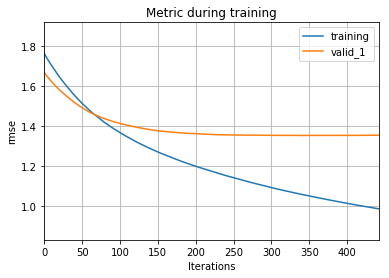

In [44]:
print(featureimp[:15])
_ = lgb.plot_metric(evals_result)

# write to submission
sub = pd.read_csv('./data/sample_submission.csv')
sub["target"] = pred_test_full_seed
sub.to_csv('submission.csv', index=False)